In [1]:
# ==========================================
# 1. CONFIGURATION (Tweaked for Speed/Safety)
# ==========================================
import os

class Config:
    DATASET_PATH = 'gpiosenka/butterfly-images40-species'
    IMAGE_SIZE = (224, 224)
    BATCH_SIZE = 32
    EPOCHS = 15
    LEARNING_RATE = 3 * (1e-3)
    FINE_TUNE_LR = 1e-5
    SEED = 42
    MODEL_NAME = "ConvNeXtTiny"

print(f"Configuration Loaded. Model: {Config.MODEL_NAME}")

Configuration Loaded. Model: ConvNeXtTiny


In [2]:
# ==========================================
# 2. IMPORTS & SETUP
# ==========================================
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pathlib
import kagglehub

# Force GPU Check
gpus = tf.config.list_physical_devices('GPU')
if not gpus:
    print("WARNING: You are using CPU! Go to Runtime -> Change Runtime Type -> T4 GPU.")
else:
    print(f"Success: GPU Detected: {gpus[0]}")

tf.random.set_seed(Config.SEED)
np.random.seed(Config.SEED)

Success: GPU Detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
# ==========================================
# 3. DATA DOWNLOAD (Direct via KaggleHub)
# ==========================================
print("\n--- Downloading Dataset ---")
# Downloads to system cache (safe from RAM crashes)
path_str = kagglehub.dataset_download(Config.DATASET_PATH)
DATA_DIR = pathlib.Path(path_str)
print(f"Dataset ready at: {DATA_DIR}")

TRAIN_DIR = DATA_DIR / 'train'
VALID_DIR = DATA_DIR / 'valid'
TEST_DIR  = DATA_DIR / 'test'


--- Downloading Dataset ---
Using Colab cache for faster access to the 'butterfly-images40-species' dataset.
Dataset ready at: /kaggle/input/butterfly-images40-species


In [4]:
# ==========================================
# 4. DATA LOADING AND PIPELINE
# ==========================================
print("\n--- Loading Generators ---")

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=Config.IMAGE_SIZE,
    batch_size=Config.BATCH_SIZE,
    shuffle=True,
    seed=Config.SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VALID_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=Config.IMAGE_SIZE,
    batch_size=Config.BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=Config.IMAGE_SIZE,
    batch_size=Config.BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Classes: {num_classes}")

# CRITICAL FIX: REMOVED .cache()
# .cache() was filling  RAM with 7GB of images.
# .prefetch() reads from disk on demand. It is safer.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


--- Loading Generators ---
Found 12594 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Classes: 100


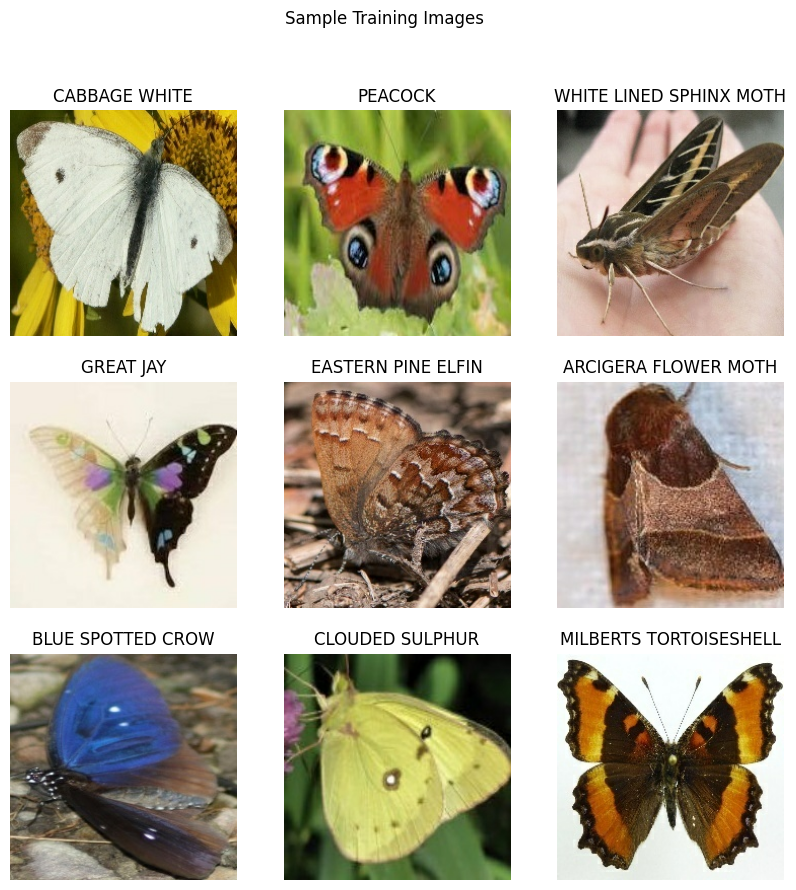

In [5]:
# ==========================================
# 5. VISUAL EDA (EXPLORATORY DATA ANALYSIS)
# ==========================================
def plot_samples(dataset, n=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(n):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            # Decode one-hot label to index
            label_index = np.argmax(labels[i])
            plt.title(class_names[label_index])
            plt.axis("off")
    plt.suptitle("Sample Training Images")
    plt.show()

plot_samples(train_ds)



In [6]:
# ==========================================
# 6. MODEL ARCHITECTURE (ConvNeXt)
# ==========================================
# Data Augmentation Layer (Inside model for GPU acceleration)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")

print(f"\n--- Building {Config.MODEL_NAME} ---")
base_model = tf.keras.applications.ConvNeXtTiny(
    include_top=False,
    weights='imagenet',
    input_shape=(Config.IMAGE_SIZE[0], Config.IMAGE_SIZE[1], 3)
)
base_model.trainable = False

inputs = keras.Input(shape=(Config.IMAGE_SIZE[0], Config.IMAGE_SIZE[1], 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=Config.LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()




--- Building ConvNeXtTiny ---
111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_tiny (Functional)      │ (None, 7, 7, 768)      │    27,820,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 768)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        76,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,897,028 (106.42 MB)

 Trainable params: 76,900 (300.39 KB)

 Non-trainable params: 27,820,128 (106.13 MB)

In [7]:
# ==========================================
# 7. TRAINING (PHASE 1: FEATURE EXTRACTION)
# ==========================================
# SAFETY NET: Saves model automatically if Colab crashes
checkpoint = callbacks.ModelCheckpoint(
    'butterfly_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("\n--- Phase 1: Training Head (Frozen Base) ---")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=Config.EPOCHS,
    callbacks=[checkpoint, early_stop]
)



--- Phase 1: Training Head (Frozen Base) ---
Epoch 1/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.3766 - loss: 2.8043
Epoch 1: val_accuracy improved from -inf to 0.74200, saving model to butterfly_best.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 152s 345ms/step - accuracy: 0.3770 - loss: 2.8020 - val_accuracy: 0.7420 - val_loss: 1.0549
Epoch 2/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.7681 - loss: 0.9540
Epoch 2: val_accuracy improved from 0.74200 to 0.81000, saving model to butterfly_best.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 128s 325ms/step - accuracy: 0.7681 - loss: 0.9538 - val_accuracy: 0.8100 - val_loss: 0.7520
Epoch 3/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.8187 - loss: 0.7006
Epoch 3: val_accuracy improved from 0.81000 to 0.82800, saving model to butterfly_best.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 128s 325ms/step - accuracy: 0.8187 - loss: 0.7005 - val_accuracy: 0.8280 - val_loss: 0.6187
Epoch 4/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/st

In [8]:
# ==========================================
# 8. TRAINING (PHASE 2: FINE TUNING)
# ==========================================
print("\n--- Phase 2: Fine-Tuning ---")
base_model.trainable = True

# Freeze bottom 70% of layers
dataset_layer_count = len(base_model.layers)
fine_tune_at = int(dataset_layer_count * 0.7)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=Config.FINE_TUNE_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=history.epoch[-1],
    epochs=history.epoch[-1] + 6,
    callbacks=[checkpoint, early_stop]
)


--- Phase 2: Fine-Tuning ---
Epoch 15/24
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.9350 - loss: 0.2140
Epoch 15: val_accuracy improved from 0.90000 to 0.92000, saving model to butterfly_best.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 295s 702ms/step - accuracy: 0.9351 - loss: 0.2139 - val_accuracy: 0.9200 - val_loss: 0.3044
Epoch 16/24
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.9542 - loss: 0.1498
Epoch 16: val_accuracy did not improve from 0.92000
394/394 ━━━━━━━━━━━━━━━━━━━━ 263s 667ms/step - accuracy: 0.9542 - loss: 0.1497 - val_accuracy: 0.9200 - val_loss: 0.2836
Epoch 17/24
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.9584 - loss: 0.1329
Epoch 17: val_accuracy improved from 0.92000 to 0.92200, saving model to butterfly_best.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 267s 679ms/step - accuracy: 0.9584 - loss: 0.1329 - val_accuracy: 0.9220 - val_loss: 0.2754
Epoch 18/24
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.9630 - loss: 0.1212
Epoch 18: v


--- Final Evaluation ---


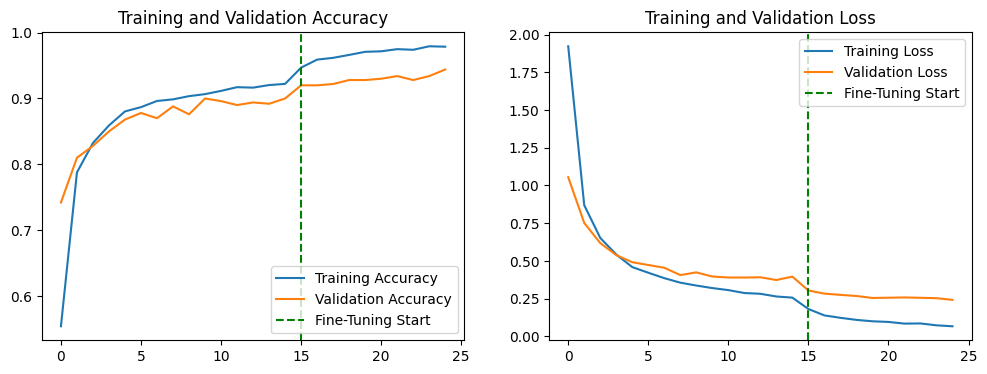

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 297ms/step - accuracy: 0.9703 - loss: 0.1034

Test Accuracy: 0.96
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 537ms/step

Classification Report:

                           precision    recall  f1-score   support

                   ADONIS       0.71      1.00      0.83         5
AFRICAN GIANT SWALLOWTAIL       1.00      1.00      1.00         5
           AMERICAN SNOOT       1.00      1.00      1.00         5
                    AN 88       1.00      1.00      1.00         5
                  APPOLLO       1.00      1.00      1.00         5
     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
                    ATALA       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      1.00      1.00         5
 BANDED ORANGE HELICONIAN       1.00      1.00      1.00         5
           BANDED PEACOCK       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      1.00      1.00         5
            BECKERS WHITE       

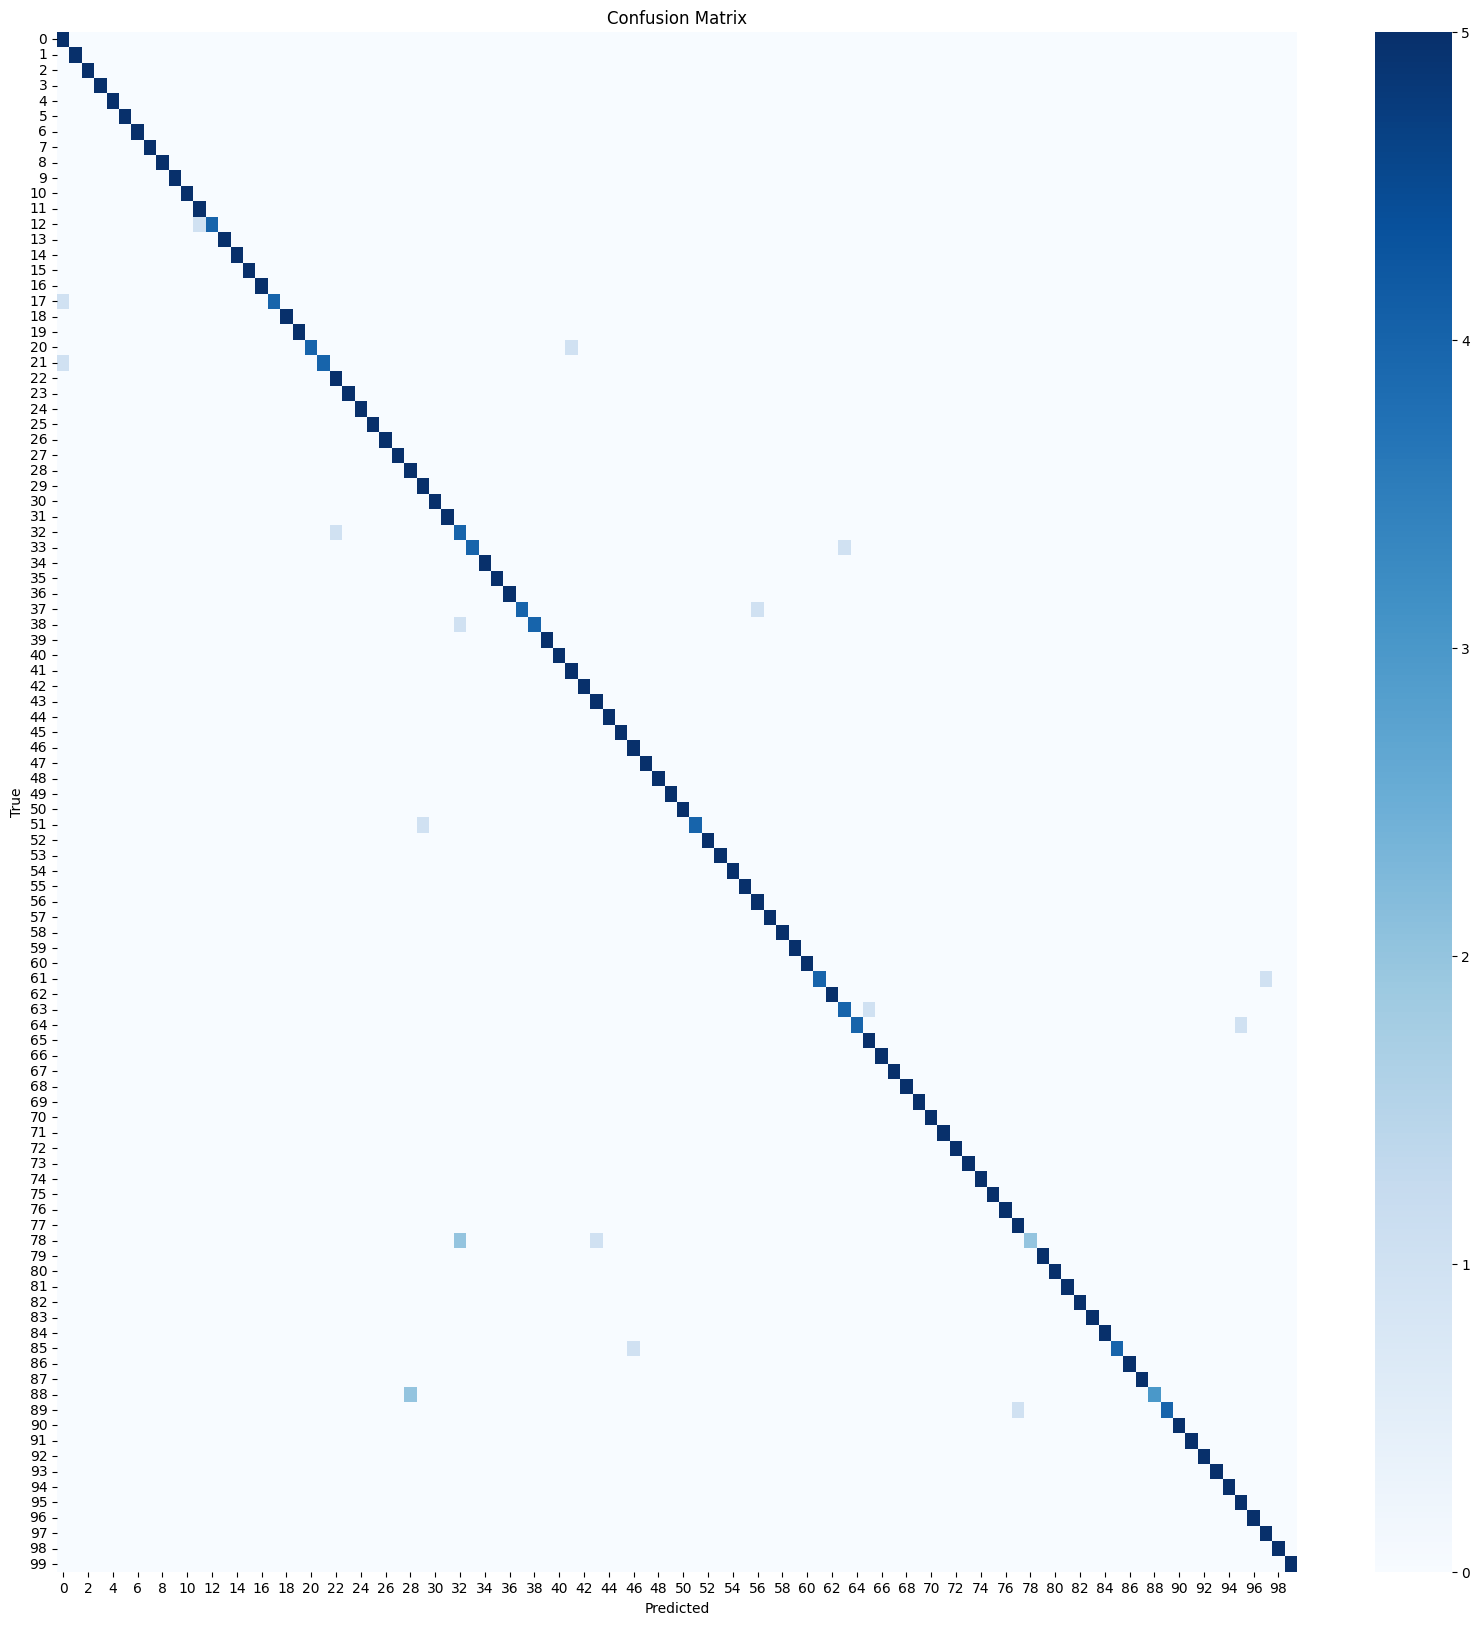

In [9]:
# ==========================================
# 9. EVALUATION & METRICS
# ==========================================
print("\n--- Final Evaluation ---")

# 1. Training Plots
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(x=len(history.history['accuracy']), color='green', linestyle='--', label='Fine-Tuning Start')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=len(history.history['accuracy']), color='green', linestyle='--', label='Fine-Tuning Start')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 2. Test Set Evaluation
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.2f}")

# 3. Confusion Matrix & Classification Report
# Get predictions
predictions = model.predict(test_ds)
y_pred = np.argmax(predictions, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix Heatmap (Optional - can be messy with 100 classes)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [10]:
# ==========================================
# 10. SAVE MODEL
# ==========================================
model.save('butterfly_convnext_final.keras')
print("Model saved successfully.")

Model saved successfully.
